<a href="https://colab.research.google.com/github/Jeromeschmidt/LendingClubLoanData/blob/main/LendingClubLoanData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lending Club Loan Data Analysis and Modeling
source: https://www.kaggle.com/wordsforthewise/lending-club

### Notes and Assumptions

- Goal: Classify different loans into grades based on included features.

- Due to Google Colab resource limits the following assumptions were made
  - Due to long training times, I made the assumption that we do not need to interpret feature importance.
  - Looking to classify high grade (A,B,C) vs low grade loans (D,E,F,G) instead of each individual grade.

- Next Improvements:
  - Additional data engineering to retain more values.
  - Explore setting NaN values instead of deleting them
    - Example: Set NaN values for mths_since_last_delinq to 0 to show that a delinquency has not been made  
  - Tune model hyperparamenters
  - Add custom NN with Keras. There is a mulit-layer perceptron implemented with SKlearn but Keras model could improve classification performance.

In [ ]:
"""
Import statements taken from https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb
"""

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

!pip3 install xgboost

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Import Data from Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load CSV from Google Drive
df=pd.read_csv('drive/MyDrive/Datasets/Loan_Data/accepted_2007_to_2018Q4.csv.gz')

df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,...,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,...,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,...,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,...,381215.0,52226.0,62500.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,...,439570.0,95768.0,20300.0,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

In [ ]:
# Get Number of entries in Dataset
len(df)

2260701

In [ ]:
# Get column types
df.dtypes

id                        object
member_id                float64
loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 151, dtype: object

In [ ]:
# Get ratio of NaN values to number of entries
(df.isna().sum()/len(df)).to_dict()

{'acc_now_delinq': 2.7425121676860406e-05,
 'acc_open_past_24mths': 0.022144901072720363,
 'addr_state': 1.4597242182845055e-05,
 'all_util': 0.3832355539277419,
 'annual_inc': 1.636660487167476e-05,
 'annual_inc_joint': 0.9466050574578416,
 'application_type': 1.4597242182845055e-05,
 'avg_cur_bal': 0.031131494169286428,
 'bc_open_to_buy': 0.03316139551404631,
 'bc_util': 0.033663894517673945,
 'chargeoff_within_12_mths': 7.873663965292182e-05,
 'collection_recovery_fee': 1.4597242182845055e-05,
 'collections_12_mths_ex_med': 7.873663965292182e-05,
 'debt_settlement_flag': 1.4597242182845055e-05,
 'debt_settlement_flag_date': 0.9848516013395845,
 'deferral_term': 0.9951709668815115,
 'delinq_2yrs': 2.7425121676860406e-05,
 'delinq_amnt': 2.7425121676860406e-05,
 'desc': 0.9442354384768264,
 'disbursement_method': 1.4597242182845055e-05,
 'dti': 0.0007714421323297508,
 'dti_joint': 0.9466068268205304,
 'earliest_cr_line': 2.7425121676860406e-05,
 'emp_length': 0.06499753837415917,
 'em

## Deal with NaN values

In [ ]:
# Gets columns that have high percentage of NaN values. Currently set to 0.3 to keep as many columns of possible.
columns_to_drop = list()
for key, value in (df.isna().sum()/len(df)).to_dict().items():
  if value >= 0.3:
    columns_to_drop.append(key)

columns_to_drop

['member_id',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_

In [ ]:
df = df.drop(columns_to_drop, axis=1)

In [ ]:
len(df)

2260701

In [ ]:
# Drops remaining rows with NaN values while still retaining significant amount of entries
df = df.dropna()

In [ ]:
len(df)

1652452

In [ ]:
# Shows new ratio of NaN entries to size of dataframe
(df.isna().sum()/len(df)).to_dict()

{'acc_now_delinq': 0.0,
 'acc_open_past_24mths': 0.0,
 'addr_state': 0.0,
 'annual_inc': 0.0,
 'application_type': 0.0,
 'avg_cur_bal': 0.0,
 'bc_open_to_buy': 0.0,
 'bc_util': 0.0,
 'chargeoff_within_12_mths': 0.0,
 'collection_recovery_fee': 0.0,
 'collections_12_mths_ex_med': 0.0,
 'debt_settlement_flag': 0.0,
 'delinq_2yrs': 0.0,
 'delinq_amnt': 0.0,
 'disbursement_method': 0.0,
 'dti': 0.0,
 'earliest_cr_line': 0.0,
 'emp_length': 0.0,
 'emp_title': 0.0,
 'fico_range_high': 0.0,
 'fico_range_low': 0.0,
 'funded_amnt': 0.0,
 'funded_amnt_inv': 0.0,
 'grade': 0.0,
 'hardship_flag': 0.0,
 'home_ownership': 0.0,
 'id': 0.0,
 'initial_list_status': 0.0,
 'inq_last_6mths': 0.0,
 'installment': 0.0,
 'int_rate': 0.0,
 'issue_d': 0.0,
 'last_credit_pull_d': 0.0,
 'last_fico_range_high': 0.0,
 'last_fico_range_low': 0.0,
 'last_pymnt_amnt': 0.0,
 'last_pymnt_d': 0.0,
 'loan_amnt': 0.0,
 'loan_status': 0.0,
 'mo_sin_old_il_acct': 0.0,
 'mo_sin_old_rev_tl_op': 0.0,
 'mo_sin_rcnt_rev_tl_op': 

## Exploratory Data Analysis

In [ ]:
df['grade'].value_counts()

C    484916
B    479340
A    304235
D    240923
E    101701
F     31886
G      9451
Name: grade, dtype: int64

In [ ]:
df['grade'].value_counts(normalize=True)

C    0.293452
B    0.290078
A    0.184111
D    0.145797
E    0.061546
F    0.019296
G    0.005719
Name: grade, dtype: float64

### Income vs. Loan Amount

In [ ]:
# Get mean income for each grade
grade_income_dict = dict()
for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['annual_inc'][df['grade'] == val].mean()))
  grade_income_dict[val] = df['annual_inc'][df['grade'] == val].mean()

A: 95176.14161700662
B: 82540.66179989153
C: 77684.05445161629
D: 74321.0093688439
E: 74425.998399819
F: 74351.22992034124
G: 76535.30607660566


<BarContainer object of 7 artists>

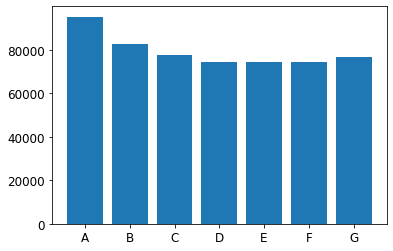

In [ ]:
plt.bar(grade_income_dict.keys(), grade_income_dict.values())

In [ ]:
# Get mean loan amount for each grade
grade_loanAmt_dict = dict()
for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['loan_amnt'][df['grade'] == val].mean()))
  grade_loanAmt_dict[val] = df['loan_amnt'][df['grade'] == val].mean()

A: 14999.26265879994
B: 14432.977531605959
C: 15348.549645711835
D: 16118.858826263993
E: 17916.70853777249
F: 19499.967070187544
G: 20844.91323669453


<BarContainer object of 7 artists>

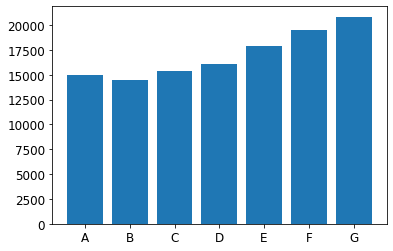

In [ ]:
plt.bar(grade_loanAmt_dict.keys(), grade_loanAmt_dict.values())

In [ ]:
income_loanAmt_dict = dict()
for key, value in grade_income_dict.items():
  print("{}: {}".format(key, grade_loanAmt_dict[key]/grade_income_dict[key]))
  income_loanAmt_dict[key] = grade_loanAmt_dict[key]/grade_income_dict[key]

A: 0.15759477537088754
B: 0.17485899939349558
C: 0.19757657802569153
D: 0.2168815919367906
E: 0.24073185342470413
F: 0.26226825152831373
G: 0.2723568285704699


<BarContainer object of 7 artists>

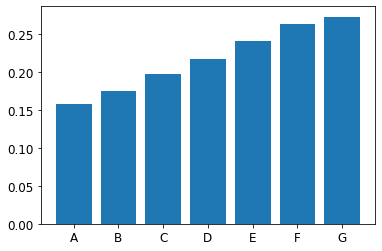

In [ ]:
plt.bar(income_loanAmt_dict.keys(), income_loanAmt_dict.values())

Generally, higher graded loan requests have have incomes and lower amounts requested. Loans with A grade typically request loans that are ~15% of their income and G graded loans are typically ~27% of the requesters income.

### Loan Amount vs Funding Amount

In [ ]:
# Get mean funded percentage for each grade
grade_fundPct_dict = dict()

for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['funded_amnt'][df['grade'] == val].sum() / df['loan_amnt'][df['grade'] == val].sum()))
  grade_fundPct_dict[val] = df['funded_amnt'][df['grade'] == val].sum() / df['loan_amnt'][df['grade'] == val].sum()

A: 0.9999969649161897
B: 1.0
C: 0.999998710155442
D: 0.9999999742493945
E: 1.0
F: 0.9999999195851818
G: 0.9999994923993787


<BarContainer object of 7 artists>

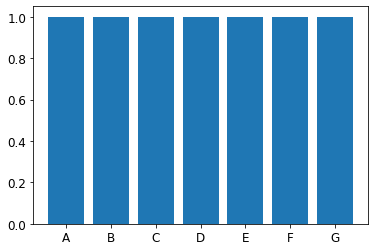

In [ ]:
plt.bar(grade_fundPct_dict.keys(), grade_fundPct_dict.values())

Funding Amount is always very close to the requested loan amount

### Visualaize Boxplots for loan amounts for each grade

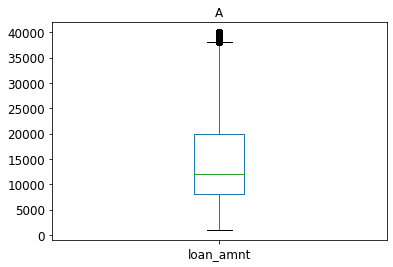

In [ ]:
# for val in df['grade'].unique():
df['loan_amnt'][df['grade'] == 'A'].plot.box(title='A')

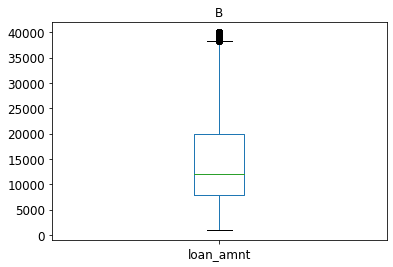

In [ ]:
df['loan_amnt'][df['grade'] == 'B'].plot.box(title='B')

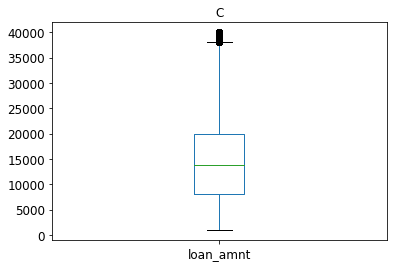

In [ ]:
df['loan_amnt'][df['grade'] == 'C'].plot.box(title='C')

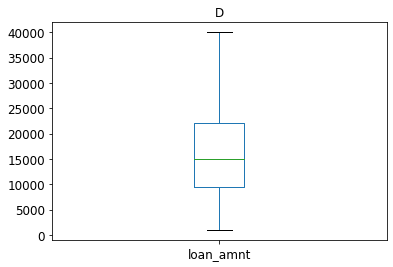

In [ ]:
df['loan_amnt'][df['grade'] == 'D'].plot.box(title='D')

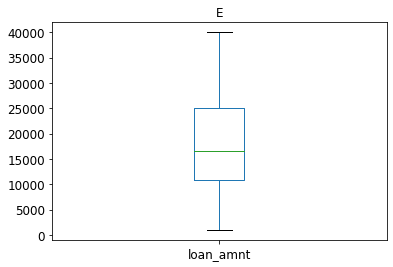

In [ ]:
df['loan_amnt'][df['grade'] == 'E'].plot.box(title='E')

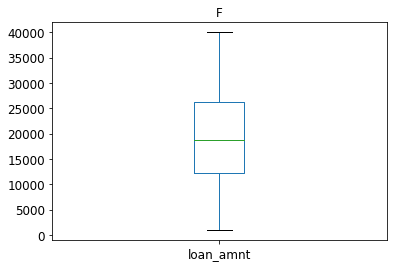

In [ ]:
df['loan_amnt'][df['grade'] == 'F'].plot.box(title='F')

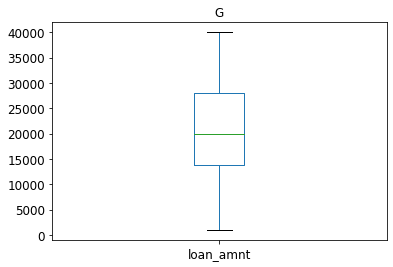

In [ ]:
df['loan_amnt'][df['grade'] == 'G'].plot.box(title='G')

### Fico Scores vs. Loan Grade

In [ ]:
# Get mean low fico for each grade
grade_ficoLow_dict = dict()
for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['fico_range_low'][df['grade'] == val].mean()))
  grade_ficoLow_dict[val] = df['fico_range_low'][df['grade'] == val].mean()

A: 727.762091804033
B: 699.4722743772687
C: 689.1262301099572
D: 683.8564396093358
E: 682.3302130755843
F: 680.4893997365615
G: 679.484181568088


<BarContainer object of 7 artists>

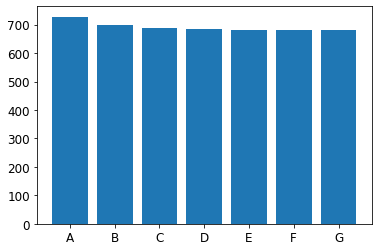

In [ ]:
plt.bar(grade_ficoLow_dict.keys(), grade_ficoLow_dict.values())

In [ ]:
# Get mean high fico for each grade
grade_ficoHigh_dict = dict()
for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['fico_range_high'][df['grade'] == val].mean()))
  grade_ficoHigh_dict[val] = df['fico_range_high'][df['grade'] == val].mean()

A: 731.7625421138265
B: 703.4723640839487
C: 693.1262466076599
D: 687.8564396093358
E: 686.3302130755843
F: 684.4894310982877
G: 683.484181568088


<BarContainer object of 7 artists>

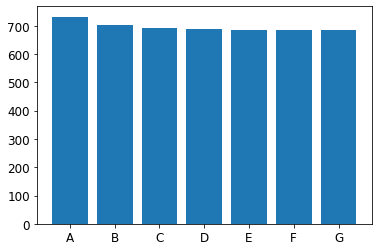

In [ ]:
plt.bar(grade_ficoHigh_dict.keys(), grade_ficoHigh_dict.values())

Loans with higher grades trend with higher FICO scores.

### Grade vs. Interest Rate

In [ ]:
# Get mean interest rate for each grade
grade_intRate_dict = dict()
for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['int_rate'][df['grade'] == val].mean()))
  grade_intRate_dict[val] = df['int_rate'][df['grade'] == val].mean()

A: 7.090198037701499
B: 10.664787144868376
C: 14.153744050557542
D: 18.176734848934537
E: 21.887480162438685
F: 25.642084300313492
G: 28.400142842026792


<BarContainer object of 7 artists>

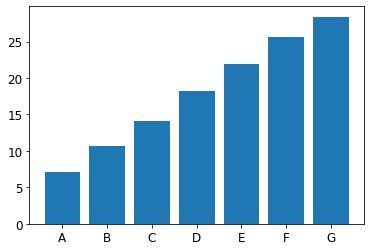

In [ ]:
plt.bar(grade_intRate_dict.keys(), grade_intRate_dict.values())

This graph shows the average interest rate for each loan grade.

## Scale Numerical Data

In [ ]:
# Shows column types
df.dtypes.to_list()

[dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtyp

In [ ]:
# Gets all columns with type 'float64'
columns_to_scale = list()

columns_to_scale = list(df.select_dtypes(include=['float64']).columns)

columns_to_scale

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,...,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,-1.277947,-1.277946,-1.277681,36 months,0.161044,-1.237905,C,C4,leadman,10+ years,MORTGAGE,-0.228887,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,-1.155373,-0.359829,Aug-2003,-0.705952,-0.705945,0.450120,-0.911764,-0.347557,-0.631579,-0.819046,-1.022654,w,-0.575321,-0.575268,-0.797524,-0.797355,-0.729255,-0.615917,...,-0.047964,-0.716183,-0.283657,0.414416,-0.607250,-0.700977,-0.082242,-0.017324,0.420499,-0.522498,-0.627558,-0.612838,-0.324315,-0.642882,-0.515952,1.031621,-0.753763,-0.504817,-0.968062,-0.615743,-0.813626,-0.951480,-0.662175,-0.509283,-0.907700,-0.023625,-0.05063,-0.165227,0.416436,-1.955042,-1.155308,-0.353645,-0.126216,-0.063120,-0.918176,-0.920494,-0.740147,N,Cash,N
1,68355089,1.007086,1.007088,1.007889,36 months,-0.250241,1.359580,C,C1,Engineer,10+ years,MORTGAGE,-0.142682,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,-0.264339,0.783612,Dec-1999,0.530809,0.530797,3.914797,1.718805,-0.347557,0.220138,-1.252513,1.048796,w,-0.575321,-0.575268,1.320854,1.321814,1.766992,-0.558222,...,0.316667,2.132049,-0.283657,-0.265692,2.715202,-1.055983,-0.082242,-0.017324,-0.238751,0.173721,-0.692088,-0.758535,1.232714,-0.709701,-1.186894,-0.384116,0.567611,-0.200349,2.837912,1.928129,-0.414241,2.431197,1.567851,-0.205632,1.724513,-0.023625,-0.05063,-0.165227,-0.126270,0.363611,-0.940456,-0.353645,-0.126216,0.677702,-0.300817,2.420022,-0.503576,N,Cash,N
4,68476807,-0.541538,-0.541537,-0.541099,60 months,1.900780,-0.616222,F,F1,Contract Specialist,3 years,MORTGAGE,0.197248,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,0.552954,0.783612,Jun-1998,-0.087572,-0.087574,2.759904,-0.034908,-0.347557,0.241038,0.617585,0.800222,w,-0.575321,-0.575268,-0.068200,-0.067758,0.075223,-0.426406,...,1.097107,-0.029829,1.615528,0.844941,-0.426687,0.715531,-0.082242,-0.017324,0.043785,0.369533,-0.563028,-0.467141,2.270734,-0.642882,-1.019158,-0.384116,0.127153,0.104120,0.069931,0.232214,0.118272,-0.317228,0.576728,0.098020,-0.030296,-0.023625,-0.05063,-0.165227,0.959143,0.273127,0.518861,-0.353645,-0.126216,1.361784,0.794490,-0.142923,0.868941,N,Cash,N
6,68476668,0.498098,0.498099,0.498781,36 months,-0.830154,0.678963,B,B2,Vice President of Recruiting Operations,10+ years,MORTGAGE,0.848669,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,550xx,MN,-0.386362,-0.359829,Jun-1990,-0.551357,-0.551352,-0.704772,-0.034908,-0.347557,3.218971,1.443236,0.137358,f,-0.575321,-0.575268,0.893763,0.894564,1.210956,-0.406935,...,1.272570,1.642987,0.349405,0.992893,-0.696087,1.608318,-0.082242,-0.017324,0.307485,1.413863,-0.175847,0.407043,1.232714,-0.3756

## Label Encode categories

### Format Grades into high vs low grade

In [ ]:
df['grade'] = np.where(  (df['grade'] == 'A') | (df['grade'] == 'B')  |  (df['grade'] == 'C'), 1, 0)

In [ ]:
df['grade'].value_counts()

1    1268491
0     383961
Name: grade, dtype: int64

In [ ]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,...,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,-1.277947,-1.277946,-1.277681,36 months,0.161044,-1.237905,1,C4,leadman,10+ years,MORTGAGE,-0.228887,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,-1.155373,-0.359829,Aug-2003,-0.705952,-0.705945,0.450120,-0.911764,-0.347557,-0.631579,-0.819046,-1.022654,w,-0.575321,-0.575268,-0.797524,-0.797355,-0.729255,-0.615917,...,-0.047964,-0.716183,-0.283657,0.414416,-0.607250,-0.700977,-0.082242,-0.017324,0.420499,-0.522498,-0.627558,-0.612838,-0.324315,-0.642882,-0.515952,1.031621,-0.753763,-0.504817,-0.968062,-0.615743,-0.813626,-0.951480,-0.662175,-0.509283,-0.907700,-0.023625,-0.05063,-0.165227,0.416436,-1.955042,-1.155308,-0.353645,-0.126216,-0.063120,-0.918176,-0.920494,-0.740147,N,Cash,N
1,68355089,1.007086,1.007088,1.007889,36 months,-0.250241,1.359580,1,C1,Engineer,10+ years,MORTGAGE,-0.142682,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,-0.264339,0.783612,Dec-1999,0.530809,0.530797,3.914797,1.718805,-0.347557,0.220138,-1.252513,1.048796,w,-0.575321,-0.575268,1.320854,1.321814,1.766992,-0.558222,...,0.316667,2.132049,-0.283657,-0.265692,2.715202,-1.055983,-0.082242,-0.017324,-0.238751,0.173721,-0.692088,-0.758535,1.232714,-0.709701,-1.186894,-0.384116,0.567611,-0.200349,2.837912,1.928129,-0.414241,2.431197,1.567851,-0.205632,1.724513,-0.023625,-0.05063,-0.165227,-0.126270,0.363611,-0.940456,-0.353645,-0.126216,0.677702,-0.300817,2.420022,-0.503576,N,Cash,N
4,68476807,-0.541538,-0.541537,-0.541099,60 months,1.900780,-0.616222,0,F1,Contract Specialist,3 years,MORTGAGE,0.197248,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,0.552954,0.783612,Jun-1998,-0.087572,-0.087574,2.759904,-0.034908,-0.347557,0.241038,0.617585,0.800222,w,-0.575321,-0.575268,-0.068200,-0.067758,0.075223,-0.426406,...,1.097107,-0.029829,1.615528,0.844941,-0.426687,0.715531,-0.082242,-0.017324,0.043785,0.369533,-0.563028,-0.467141,2.270734,-0.642882,-1.019158,-0.384116,0.127153,0.104120,0.069931,0.232214,0.118272,-0.317228,0.576728,0.098020,-0.030296,-0.023625,-0.05063,-0.165227,0.959143,0.273127,0.518861,-0.353645,-0.126216,1.361784,0.794490,-0.142923,0.868941,N,Cash,N
6,68476668,0.498098,0.498099,0.498781,36 months,-0.830154,0.678963,1,B2,Vice President of Recruiting Operations,10+ years,MORTGAGE,0.848669,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,550xx,MN,-0.386362,-0.359829,Jun-1990,-0.551357,-0.551352,-0.704772,-0.034908,-0.347557,3.218971,1.443236,0.137358,f,-0.575321,-0.575268,0.893763,0.894564,1.210956,-0.406935,...,1.272570,1.642987,0.349405,0.992893,-0.696087,1.608318,-0.082242,-0.017324,0.307485,1.413863,-0.175847,0.407043,1.232714,-0.3756

In [ ]:
# Shows column types
df.dtypes.to_list()

[dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 

In [ ]:
# Gets all columns with type 'object'
columns_to_encode = list()

columns_to_encode = list(df.select_dtypes(include=['object']).columns)

columns_to_encode

['id',
 'term',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

In [ ]:
# Casts columns of type 'object' to type 'str' to label encode
df[columns_to_encode] = df[columns_to_encode].astype('str')

In [ ]:
# Encodes all columns that were previously type 'object'
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df[columns_to_encode] = df[columns_to_encode].apply(encoder.fit_transform)

In [ ]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,...,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,1240179,-1.277947,-1.277946,-1.277681,0,0.161044,-1.237905,1,13,377362,1,1,-0.228887,0,16,3,0,1240179,2,8963,181,38,-1.155373,-0.359829,108,-0.705952,-0.705945,0.450120,-0.911764,-0.347557,-0.631579,-0.819046,-1.022654,1,-0.575321,-0.575268,-0.797524,-0.797355,-0.729255,-0.615917,...,-0.047964,-0.716183,-0.283657,0.414416,-0.607250,-0.700977,-0.082242,-0.017324,0.420499,-0.522498,-0.627558,-0.612838,-0.324315,-0.642882,-0.515952,1.031621,-0.753763,-0.504817,-0.968062,-0.615743,-0.813626,-0.951480,-0.662175,-0.509283,-0.907700,-0.023625,-0.05063,-0.165227,0.416436,-1.955042,-1.155308,-0.353645,-0.126216,-0.063120,-0.918176,-0.920494,-0.740147,0,0,0
1,1238204,1.007086,1.007088,1.007889,0,-0.250241,1.359580,1,10,111758,1,1,-0.142682,0,16,3,0,1238204,11,2356,551,41,-0.264339,0.783612,163,0.530809,0.530797,3.914797,1.718805,-0.347557,0.220138,-1.252513,1.048796,1,-0.575321,-0.575268,1.320854,1.321814,1.766992,-0.558222,...,0.316667,2.132049,-0.283657,-0.265692,2.715202,-1.055983,-0.082242,-0.017324,-0.238751,0.173721,-0.692088,-0.758535,1.232714,-0.709701,-1.186894,-0.384116,0.567611,-0.200349,2.837912,1.928129,-0.414241,2.431197,1.567851,-0.205632,1.724513,-0.023625,-0.05063,-0.165227,-0.126270,0.363611,-0.940456,-0.353645,-0.126216,0.677702,-0.300817,2.420022,-0.503576,0,0,0
4,1242225,-0.541538,-0.541537,-0.541099,1,1.900780,-0.616222,0,25,71879,3,1,0.197248,1,16,3,0,1242225,6,15927,165,38,0.552954,0.783612,406,-0.087572,-0.087574,2.759904,-0.034908,-0.347557,0.241038,0.617585,0.800222,1,-0.575321,-0.575268,-0.068200,-0.067758,0.075223,-0.426406,...,1.097107,-0.029829,1.615528,0.844941,-0.426687,0.715531,-0.082242,-0.017324,0.043785,0.369533,-0.563028,-0.467141,2.270734,-0.642882,-1.019158,-0.384116,0.127153,0.104120,0.069931,0.232214,0.118272,-0.317228,0.576728,0.098020,-0.030296,-0.023625,-0.05063,-0.165227,0.959143,0.273127,0.518861,-0.353645,-0.126216,1.361784,0.794490,-0.142923,0.868941,0,0,0
6,1242213,0.498098,0.498099,0.498781,0,-0.830154,0.678963,1,6,344086,1,1,0.848669,0,16,3,0,1242213,2,8963,524,23,-0.386362,-0.359829,398,-0.551357,-0.551352,-0.704772,-0.034908,-0.347557,3.218971,1.443236,0.137358,0,-0.575321,-0.575268,0.893763,0.894564,1.210956,-0.406935,...,1.272570,1.642987,0.349405,0.992893,-0.696087,1.608318,-0.082242,-0.017324,0.307485,1.413863,-0.175847,0.407043,1.232714,-0.375608,0.490460,-0.384116,0.127153,0.104120,-0.276067,-0.615743,-0.281113,0.105607,0.205057,0.098020,-0.030296,-0.023625,-0.05063,-0.165227,-0.126270,0.239195,1.634974,-0.353645,-0.126216,1.085445,1.202976,0.343603,-0.032186,0,0,0
7,1224668,0.498098,0.498099,0.498781,0,-0.969991,0.655419,1,5,391407,1,1,0.029727,0,16,3,0,1224668,6,15927,282,40,-0.128270,0.783612,220,0.221618,0.221611,-0.704772,-0.736393,-0.347557,-0.719869,-1.809826,-0.856938,1,-0.575321,-0.575268,0.908184,0.908990,1.210956,-0.354073,...,-0.068208,-0.571688,-0.283657,0.228329,0.110518,-1.8

## PCA

Note: PCA is primarily being done to reduce the compute time.

In [ ]:
# Graphs Column correlations
corr = df.corr()
corr.style.background_gradient()

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


In [ ]:
# Test PCA with different amount of components to determine optimal number of components

from sklearn.decomposition import PCA

explained_variance_list = list()

for i in range(20, 1, -1):
  pca = PCA(n_components=i)

  temp_df = df.drop(['grade', 'sub_grade'], axis=1)

  PCA_df = pca.fit_transform(temp_df)
  explained_variance_list.append(pca.explained_variance_ratio_.sum())
  print(pca.explained_variance_ratio_.sum())

0.9999999999315518
0.9999999999268601
0.9999999999216368
0.9999999999157896
0.9999999999094349
0.9999999999022681
0.9999999998946547
0.9999999998853019
0.9999999998741458
0.999999999859795
0.9999999998392167
0.9999999998151773
0.9999999993788499
0.9999999989209347
0.9999999981770554
0.9999999971311788
0.9999998972095635
0.9999997140783975
0.9999622887147592


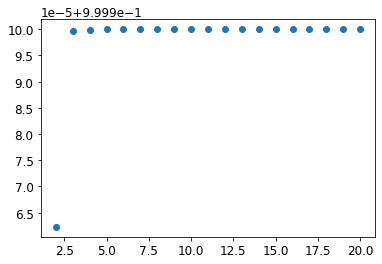

In [ ]:
# Uses Elbow method to determine optional number of components
plt.scatter(x=[i for i in range(20,1,-1)],y=explained_variance_list)

There's diminishing return after 10 components so we'll use 10 moving forward

In [ ]:
# Makes PCA Dataframe that we will use to represent features
pca = PCA(n_components=10)

temp_df = df.drop(['grade', 'sub_grade'], axis=1)

PCA_df = pca.fit_transform(temp_df)

In [ ]:
# Seperates features df and target df, in this case grades
feature_columns = PCA_df

grade_df = df['grade']

sub_grade_df = df['sub_grade']

In [ ]:
feature_columns

array([[ 5.85845222e+05, -1.70224441e+05, -1.31699836e+03, ...,
         1.10022473e+01, -8.57464507e+00, -2.45035954e+00],
       [ 5.82388559e+05,  9.53818177e+04, -7.50664492e+03, ...,
         1.84818515e+01, -4.94355580e+00,  5.63074885e+00],
       [ 5.87977009e+05,  1.35253520e+05,  6.12637725e+03, ...,
         1.09800579e+01, -6.11284856e+00,  1.97319184e+00],
       ...,
       [ 9.57469841e+05,  1.29736118e+05, -3.05471020e+03, ...,
        -7.12552326e+00, -2.14700000e+00,  2.97632463e+00],
       [ 9.46121340e+05,  1.23919372e+05, -8.93619670e+02, ...,
         2.45675111e+01, -2.01067149e+00,  6.50848298e+00],
       [ 9.28821359e+05, -3.42311195e+04, -1.14006765e+03, ...,
        -1.62462477e+01,  5.04725144e+00, -1.51052128e+00]])

In [ ]:
grade_df

0          1
1          1
4          0
6          1
7          1
          ..
2260691    1
2260692    1
2260693    1
2260695    1
2260697    1
Name: grade, Length: 1652452, dtype: int64

## Split data into training, validation, and testing

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_columns, grade_df, test_size=0.15)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20)

## Build and Test Models

In [ ]:
models = list()

### K Neighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn.score(X_valid, y_valid)

0.7229074780095188

In [ ]:
models.append(("knn", knn))

### Decision Tree

In [ ]:
from sklearn import tree

decTree = tree.DecisionTreeClassifier()

decTree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
decTree.score(X_valid, y_valid)

0.6546844797573661

In [ ]:
models.append(("decTree", decTree))

### SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()

sgd.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd.score(X_valid, y_valid)

0.523948354852145

In [ ]:
models.append(("sgd", sgd))

### XGBoost

In [ ]:
import xgboost as xgb

xgbClas = xgb.XGBClassifier(n_jobs=-1)

xgbClas.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgbClas.score(X_valid, y_valid)

0.7672728955527789

In [ ]:
models.append(("xgbClas", xgbClas))

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RanForest = RandomForestClassifier(n_jobs=-1)

RanForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
RanForest.score(X_valid, y_valid)

0.7658952644375385

In [ ]:
models.append(("RanForest", RanForest))

### MLP Classifier


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=300, early_stopping=True)

mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
mlp.score(X_valid, y_valid)

0.7637131252291602

In [ ]:
models.append(("mlp", mlp))

### Compare model Metrics

In [ ]:
# function to get necessary metrics
from sklearn.metrics import confusion_matrix


def get_metrics(confusion):
    acc = (confusion[0][0] + confusion[1][1])/(confusion[0][0] + confusion[1][1] + confusion[0][1] + confusion[1][0])
    
    prec = (confusion[1][1])/(confusion[1][1] + confusion[1][0])
    
    recall = (confusion[1][1])/(confusion[1][1] + confusion[0][1])
    
    clas = (confusion[0][1] + confusion[1][0])/(confusion[0][1] + confusion[1][1] + confusion[0][1] + confusion[1][0])
    
    spec = (confusion[0][0])/(confusion[0][0] + confusion[0][1])
    
    f1 = 2*((prec*recall)/(prec+recall))
    
    print("acc: " + str(acc))
    print("prec: " + str(prec))
    print("recall: " + str(recall))
    print("clas: " + str(clas))
    print("spec: " + str(spec))
    print("f1: " + str(f1))
    return acc, prec, recall, clas, spec, f1

In [ ]:
model_metrics = dict()
for model in models:
  print(model[0])
  y_pred = model[1].predict(X_valid)

  model_matrix = confusion_matrix(y_valid, y_pred)

  model_acc, model_prec, model_recall, model_clas, model_spec, model_f1 = get_metrics(model_matrix)

  model_metrics[model[0]] = dict()
  model_metrics[model[0]]["acc"] = model_acc
  model_metrics[model[0]]["prec"] = model_prec
  model_metrics[model[0]]["recall"] = model_recall
  model_metrics[model[0]]["clas"] = model_clas
  model_metrics[model[0]]["spec"] = model_spec
  model_metrics[model[0]]["f1"] = model_f1
  print("--------------------------")

knn
acc: 0.7229074780095188
prec: 0.9054921193168374
recall: 0.7725083026889232
clas: 0.23554402984848805
spec: 0.12110414436458174
f1: 0.8337306367962816
--------------------------
decTree
acc: 0.6546844797573661
prec: 0.7645631405809945
recall: 0.7807966035840528
clas: 0.3148991563085333
spec: 0.29252179232298514
f1: 0.7725946086601825
--------------------------
sgd
acc: 0.523948354852145
prec: 0.5259433852835144
recall: 0.7822225595870654
clas: 0.4799332483984999
spec: 0.5173726869551919
f1: 0.6289795001123624
--------------------------
xgbClas
acc: 0.7672728955527789
prec: 0.9999118439917041
recall: 0.7672982845912285
clas: 0.18881825769762856
spec: 0.0004893714635265331
f1: 0.8682958865253941
--------------------------
RanForest
acc: 0.7658952644375385
prec: 0.9812970068715289
recall: 0.7740613185276819
clas: 0.19399810615558433
spec: 0.05592598256614161
f1: 0.8654461530907037
--------------------------
mlp
acc: 0.7637131252291602
prec: 0.992599535093051
recall: 0.767568188178563


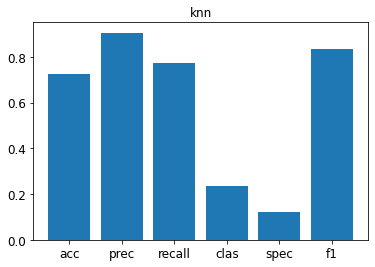

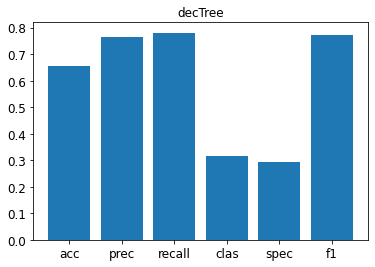

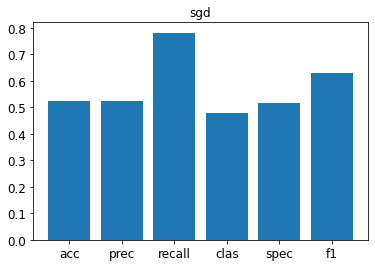

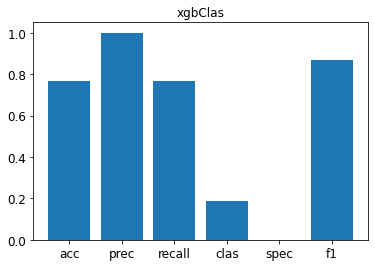

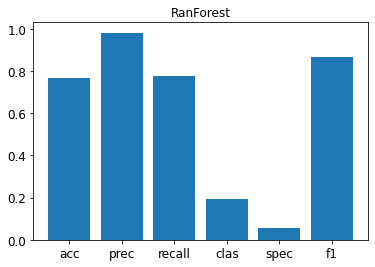

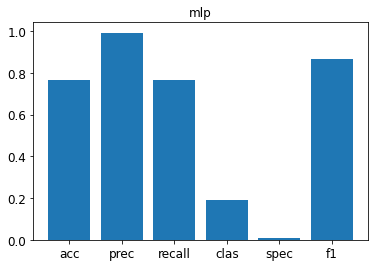

In [ ]:
for key, value in model_metrics.items():
  plt.bar(value.keys(), value.values())
  plt.title(key)
  plt.show()

### Grid Search on Random Forest Classifier
Causes Colab to crach but this is how I would do it.

In [ ]:
# # https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6
# from sklearn.model_selection import GridSearchCV

# n_estimators = [100, 300, 500, 800, 1200]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 

# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# gridF = GridSearchCV(RanForest, hyperF, cv = 3, verbose = 1)
# bestF = gridF.fit(X_train, y_train)

In [ ]:
# bestF.score(X_valid, y_valid)

## Run Models on Testing Data

In [ ]:
model_metrics = dict()

metric_model = dict()
metric_model["acc"] = dict()
metric_model["prec"] = dict()
metric_model["recall"] = dict()
metric_model["clas"] = dict()
metric_model["spec"] = dict()
metric_model["f1"] = dict()

for model in models:
  print(model[0])
  y_pred = model[1].predict(X_test)

  model_matrix = confusion_matrix(y_test, y_pred)

  model_acc, model_prec, model_recall, model_clas, model_spec, model_f1 = get_metrics(model_matrix)

  model_metrics[model[0]] = dict()
  model_metrics[model[0]]["acc"] = model_acc
  model_metrics[model[0]]["prec"] = model_prec
  model_metrics[model[0]]["recall"] = model_recall
  model_metrics[model[0]]["clas"] = model_clas
  model_metrics[model[0]]["spec"] = model_spec
  model_metrics[model[0]]["f1"] = model_f1


  metric_model["acc"][model[0]] = model_acc
  metric_model["prec"][model[0]] = model_prec
  metric_model["recall"][model[0]] = model_recall
  metric_model["clas"][model[0]] = model_clas
  metric_model["spec"][model[0]] = model_spec
  metric_model["f1"][model[0]] = model_f1
  print("--------------------------")

knn
acc: 0.7231469975954944
prec: 0.9063294470616101
recall: 0.7720925852853607
clas: 0.23530117714023158
spec: 0.12190107630910631
f1: 0.8338430173292559
--------------------------
decTree
acc: 0.6558208401245824
prec: 0.7667394794325868
recall: 0.7803807911541594
clas: 0.31367221251953303
spec: 0.2917609660867612
f1: 0.7734999960175124
--------------------------
sgd
acc: 0.5233592073200252
prec: 0.5236992394136379
recall: 0.7825071372956138
clas: 0.48164440077784526
spec: 0.522243145655892
f1: 0.6274634697005051
--------------------------
xgbClas
acc: 0.7665531653944841
prec: 0.9998894649577599
recall: 0.7665804436517129
clas: 0.1893015693343497
spec: 0.0006910491854257727
f1: 0.8678276441780571
--------------------------
RanForest
acc: 0.7655122887988768
prec: 0.9821091138774114
recall: 0.7732243720706646
clas: 0.1941081584739055
spec: 0.05459288564863604
f1: 0.8652380974462895
--------------------------
mlp
acc: 0.7626882050123452
prec: 0.9923625549385477
recall: 0.7666944551757793

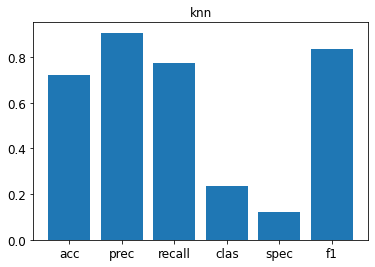

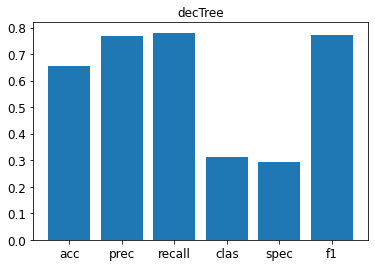

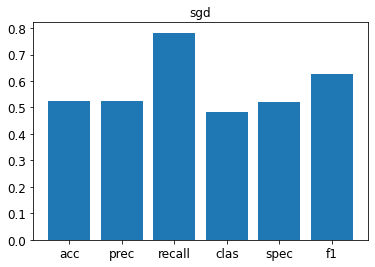

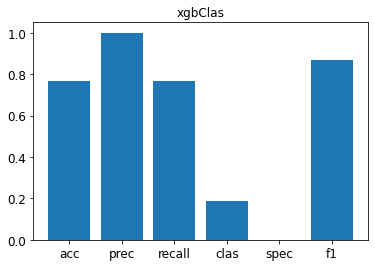

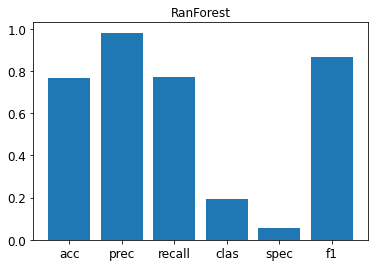

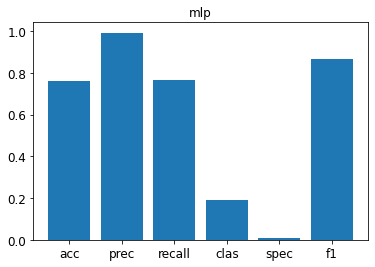

In [ ]:
for key, value in model_metrics.items():
  plt.bar(value.keys(), value.values())
  plt.title(key)
  plt.show()

In [ ]:
print(metric_model)
# print(models)

{'acc': {'knn': 0.7231469975954944, 'decTree': 0.6558208401245824, 'sgd': 0.5233592073200252, 'xgbClas': 0.7665531653944841, 'RanForest': 0.7655122887988768, 'mlp': 0.7626882050123452}, 'prec': {'knn': 0.9063294470616101, 'decTree': 0.7667394794325868, 'sgd': 0.5236992394136379, 'xgbClas': 0.9998894649577599, 'RanForest': 0.9821091138774114, 'mlp': 0.9923625549385477}, 'recall': {'knn': 0.7720925852853607, 'decTree': 0.7803807911541594, 'sgd': 0.7825071372956138, 'xgbClas': 0.7665804436517129, 'RanForest': 0.7732243720706646, 'mlp': 0.7666944551757793}, 'clas': {'knn': 0.23530117714023158, 'decTree': 0.31367221251953303, 'sgd': 0.48164440077784526, 'xgbClas': 0.1893015693343497, 'RanForest': 0.1941081584739055, 'mlp': 0.19303179567284814}, 'spec': {'knn': 0.12190107630910631, 'decTree': 0.2917609660867612, 'sgd': 0.522243145655892, 'xgbClas': 0.0006910491854257727, 'RanForest': 0.05459288564863604, 'mlp': 0.00884542957344989}, 'f1': {'knn': 0.8338430173292559, 'decTree': 0.773499996017

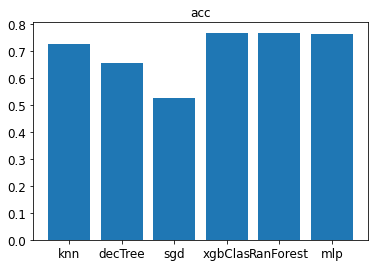

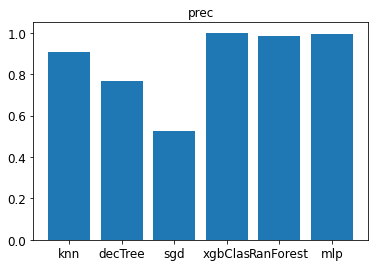

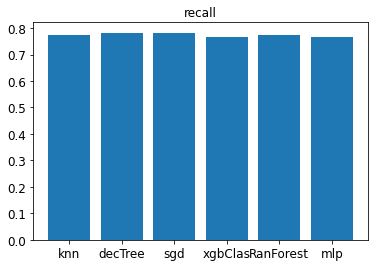

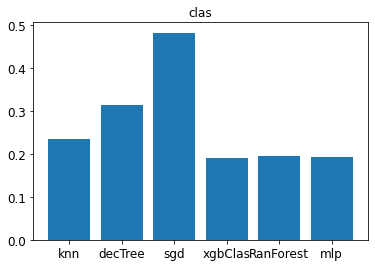

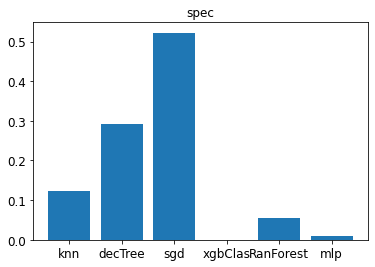

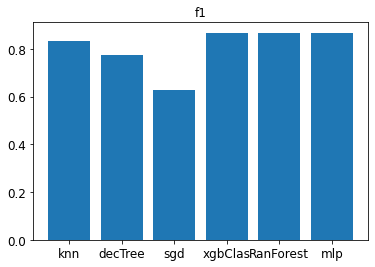

In [ ]:
for key, value in metric_model.items():
  plt.bar(value.keys(), value.values())
  plt.title(key)
  plt.show()

Given the model results on testing data, a tree based algorithm is likely the best for high accuracy. Either Random Forest or XGBoost would be the optimal choice.

## Resources:

https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

https://scikit-learn.org/stable/index.html

https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

